In [1]:
%%capture
!pip install scikit-plot

In [10]:
pip install --upgrade scikit-plot


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
#import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Loading Data

In [19]:
data = pd.read_csv(r"C:\Users\dsilv\development\Emotion Detection\data\fer2013.csv")
data.shape

(35887, 3)

In [20]:
data.isnull().sum()


emotion    0
pixels     0
Usage      0
dtype: int64

In [21]:
data.head()


emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

Data pre-processing

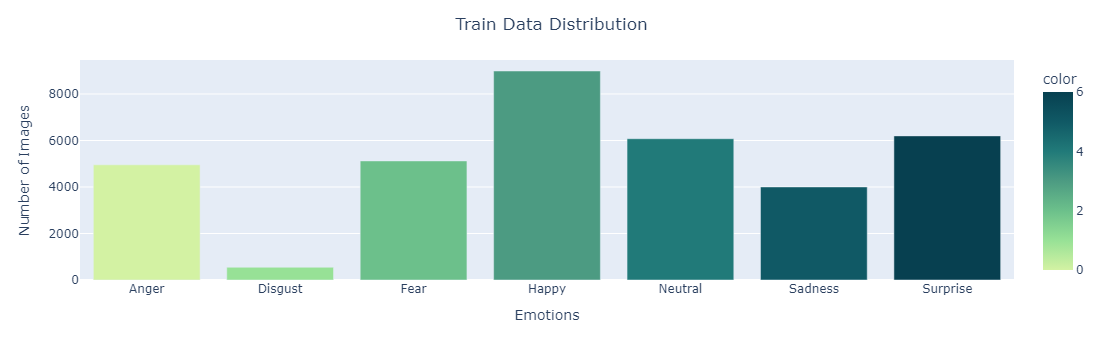

In [22]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [23]:
data = data.sample(frac=1)

In [24]:
labels = to_categorical(data[['emotion']], num_classes=7)

In [25]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

In [28]:
pixels = train_pixels.reshape((35887*2304,1))

In [29]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [30]:
pixels = train_pixels.reshape((35887, 48, 48,1))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


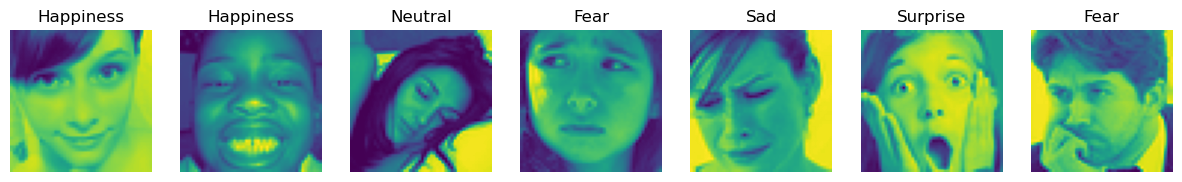

In [34]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

In [35]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [36]:
datagen.fit(X_train)
valgen.fit(X_val)

In [37]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

CNN Model

In [47]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [48]:
model = cnn_model()

In [50]:
model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,810,183 (22.16 MB)

 Trainable params: 5,805,191 (22.15 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [58]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.keras',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [60]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=checkpointer,
                    validation_data=val_generator)

Epoch 1/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1704 - loss: 14.5918
Epoch 1: val_accuracy improved from -inf to 0.24149, saving model to best_model.keras
455/455 ━━━━━━━━━━━━━━━━━━━━ 164s 352ms/step - accuracy: 0.1704 - loss: 14.5908 - val_accuracy: 0.2415 - val_loss: 12.9979
Epoch 2/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.2052 - loss: 12.7934
Epoch 2: val_accuracy improved from 0.24149 to 0.25913, saving model to best_model.keras
455/455 ━━━━━━━━━━━━━━━━━━━━ 231s 509ms/step - accuracy: 0.2052 - loss: 12.7924 - val_accuracy: 0.2591 - val_loss: 11.2484
Epoch 3/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.2188 - loss: 10.9176
Epoch 3: val_accuracy improved from 0.25913 to 0.27090, saving model to best_model.keras
455/455 ━━━━━━━━━━━━━━━━━━━━ 276s 606ms/step - accuracy: 0.2188 - loss: 10.9166 - val_accuracy: 0.2709 - val_loss: 9.2653
Epoch 4/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.2351 - loss: 9.0122
Epoch 4: val_

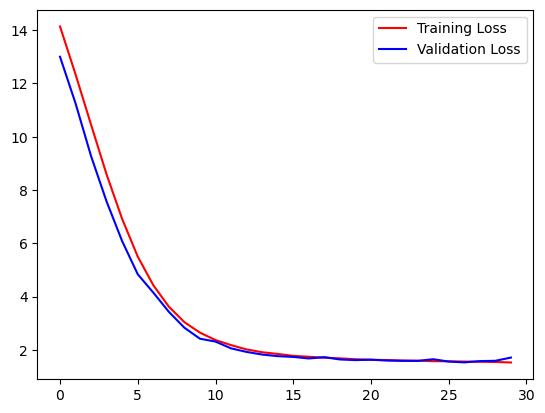

In [61]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

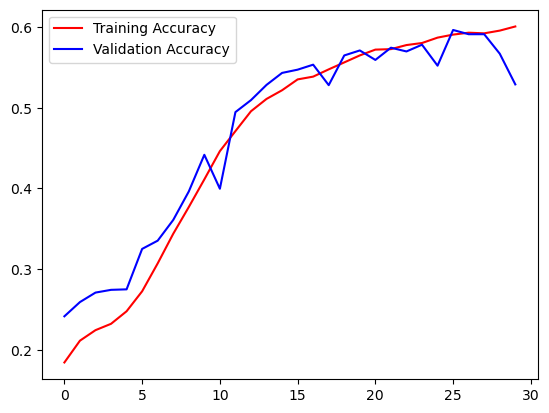

In [62]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [63]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5783 - loss: 1.5574
Test Acc: 0.5848425626754761


In [64]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step


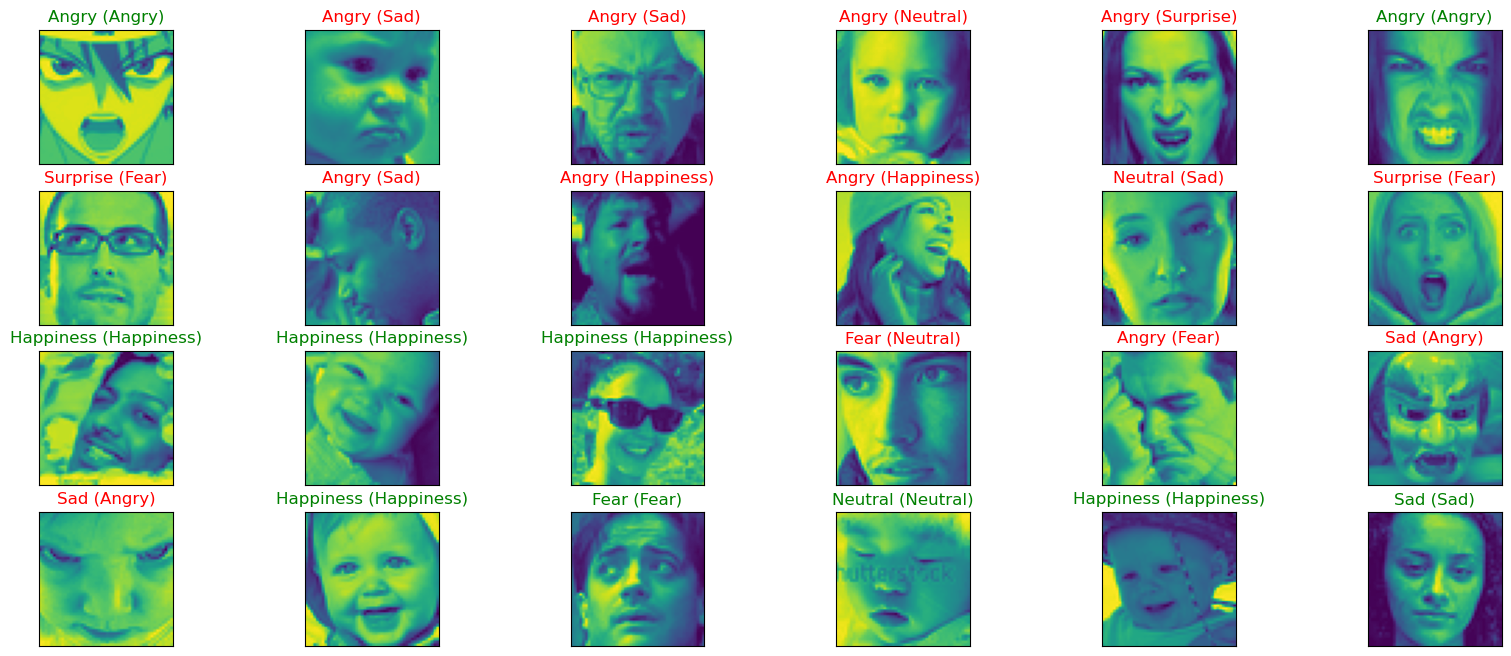

In [66]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

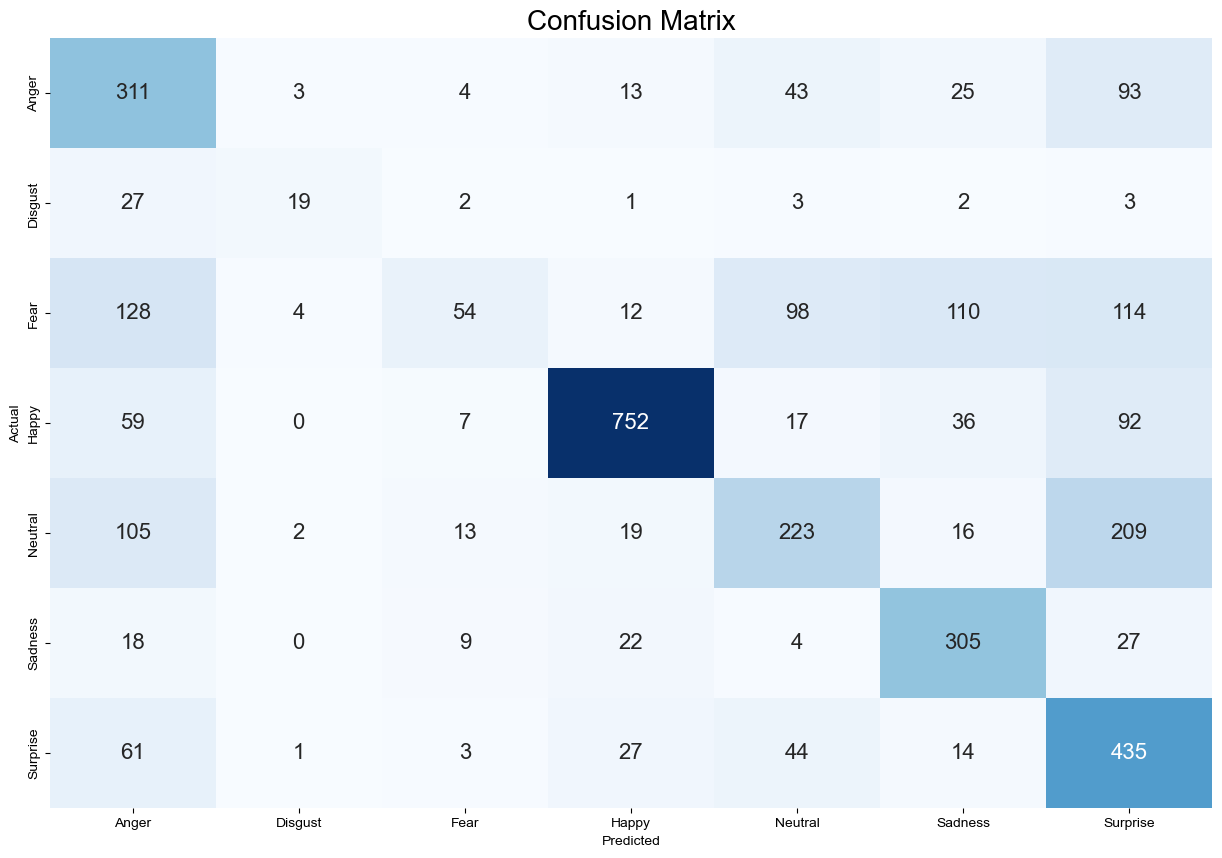

In [67]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [68]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.439     0.632     0.518       492
           1      0.655     0.333     0.442        57
           2      0.587     0.104     0.176       520
           3      0.889     0.781     0.831       963
           4      0.516     0.380     0.438       587
           5      0.600     0.792     0.683       385
           6      0.447     0.744     0.558       585

    accuracy                          0.585      3589
   macro avg      0.590     0.538     0.521      3589
weighted avg      0.616     0.585     0.563      3589



Optimising

In [70]:
model = cnn_model()

In [71]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [73]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=checkpointer,
                    validation_data=val_generator)

Epoch 1/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.1524 - loss: 14.9573
Epoch 1: val_accuracy did not improve from 0.59659
455/455 ━━━━━━━━━━━━━━━━━━━━ 148s 321ms/step - accuracy: 0.1524 - loss: 14.9570 - val_accuracy: 0.2111 - val_loss: 14.0742
Epoch 2/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.1735 - loss: 14.4852
Epoch 2: val_accuracy did not improve from 0.59659
455/455 ━━━━━━━━━━━━━━━━━━━━ 157s 346ms/step - accuracy: 0.1735 - loss: 14.4850 - val_accuracy: 0.2124 - val_loss: 13.8121
Epoch 3/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.1860 - loss: 14.1360
Epoch 3: val_accuracy did not improve from 0.59659
455/455 ━━━━━━━━━━━━━━━━━━━━ 151s 331ms/step - accuracy: 0.1860 - loss: 14.1358 - val_accuracy: 0.2362 - val_loss: 13.5638
Epoch 4/30
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.1911 - loss: 13.8309
Epoch 4: val_accuracy did not improve from 0.59659
455/455 ━━━━━━━━━━━━━━━━━━━━ 150s 329ms/step - accuracy: 0.1911 - loss:

In [74]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.2103 - loss: 14.0735
Test Acc: 0.21315129101276398


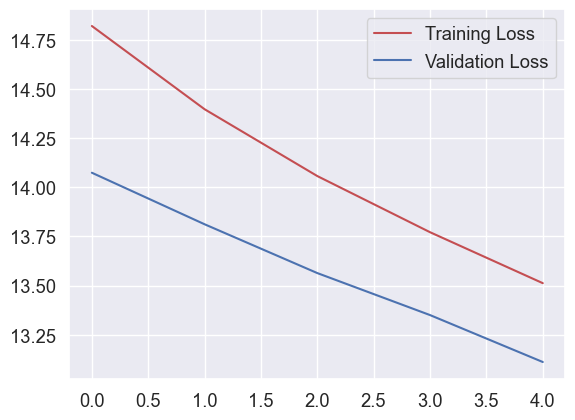

In [75]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

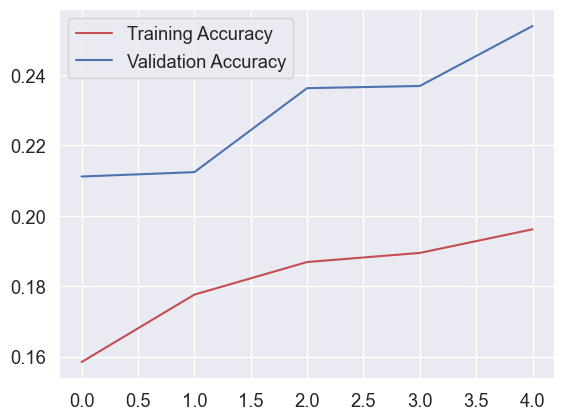

In [76]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

Changing number of Epochs

In [77]:
model = cnn_model()

In [79]:
model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [82]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.keras',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [84]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=checkpointer,
                    validation_data=val_generator)

Epoch 1/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.1656 - loss: 14.5955
Epoch 1: val_accuracy improved from -inf to 0.21950, saving model to best_model.keras
455/455 ━━━━━━━━━━━━━━━━━━━━ 159s 343ms/step - accuracy: 0.1656 - loss: 14.5944 - val_accuracy: 0.2195 - val_loss: 12.9204
Epoch 2/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.2085 - loss: 12.7294
Epoch 2: val_accuracy improved from 0.21950 to 0.26068, saving model to best_model.keras
455/455 ━━━━━━━━━━━━━━━━━━━━ 170s 374ms/step - accuracy: 0.2085 - loss: 12.7284 - val_accuracy: 0.2607 - val_loss: 11.0314
Epoch 3/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.2273 - loss: 10.7934
Epoch 3: val_accuracy did not improve from 0.26068
455/455 ━━━━━━━━━━━━━━━━━━━━ 165s 362ms/step - accuracy: 0.2273 - loss: 10.7924 - val_accuracy: 0.2601 - val_loss: 9.2041
Epoch 4/50
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.2423 - loss: 8.9245
Epoch 4: val_accuracy improved from 0.26068 to 0.29

In [85]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.6155 - loss: 1.4640
Test Acc: 0.6182780861854553


In [86]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step


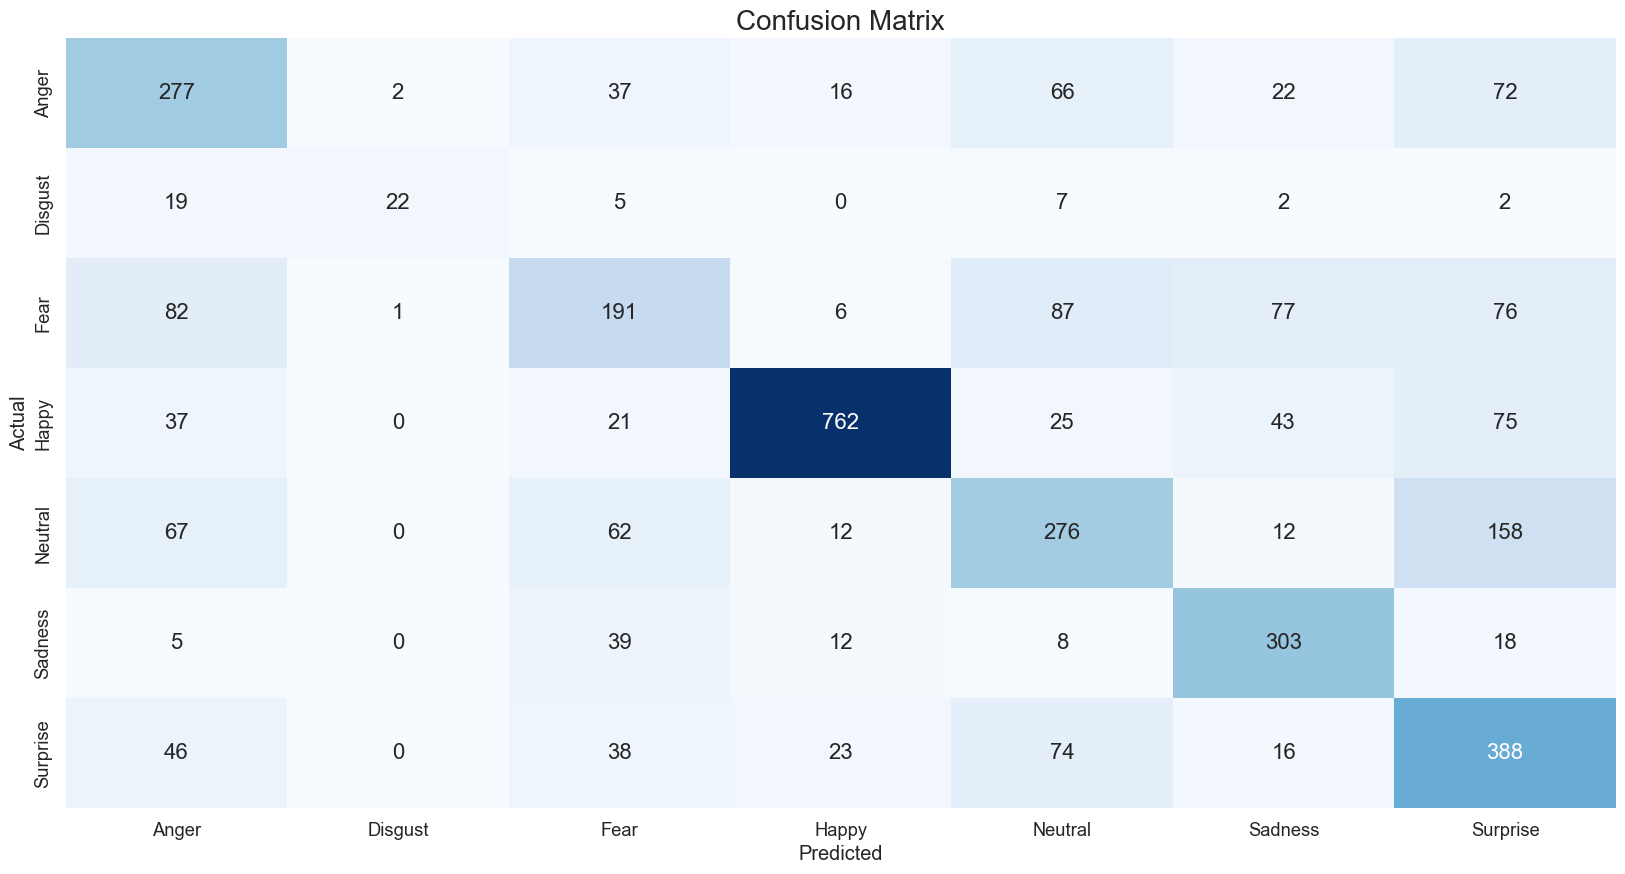

In [87]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [88]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))


              precision    recall  f1-score   support

           0      0.520     0.563     0.540       492
           1      0.880     0.386     0.537        57
           2      0.486     0.367     0.418       520
           3      0.917     0.791     0.849       963
           4      0.508     0.470     0.488       587
           5      0.638     0.787     0.705       385
           6      0.492     0.663     0.565       585

    accuracy                          0.618      3589
   macro avg      0.634     0.575     0.586      3589
weighted avg      0.633     0.618     0.619      3589



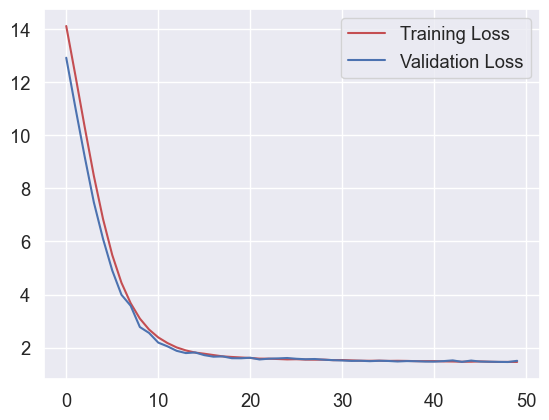

In [89]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

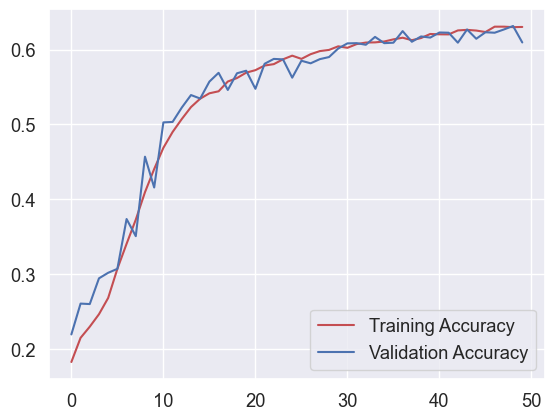

In [90]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

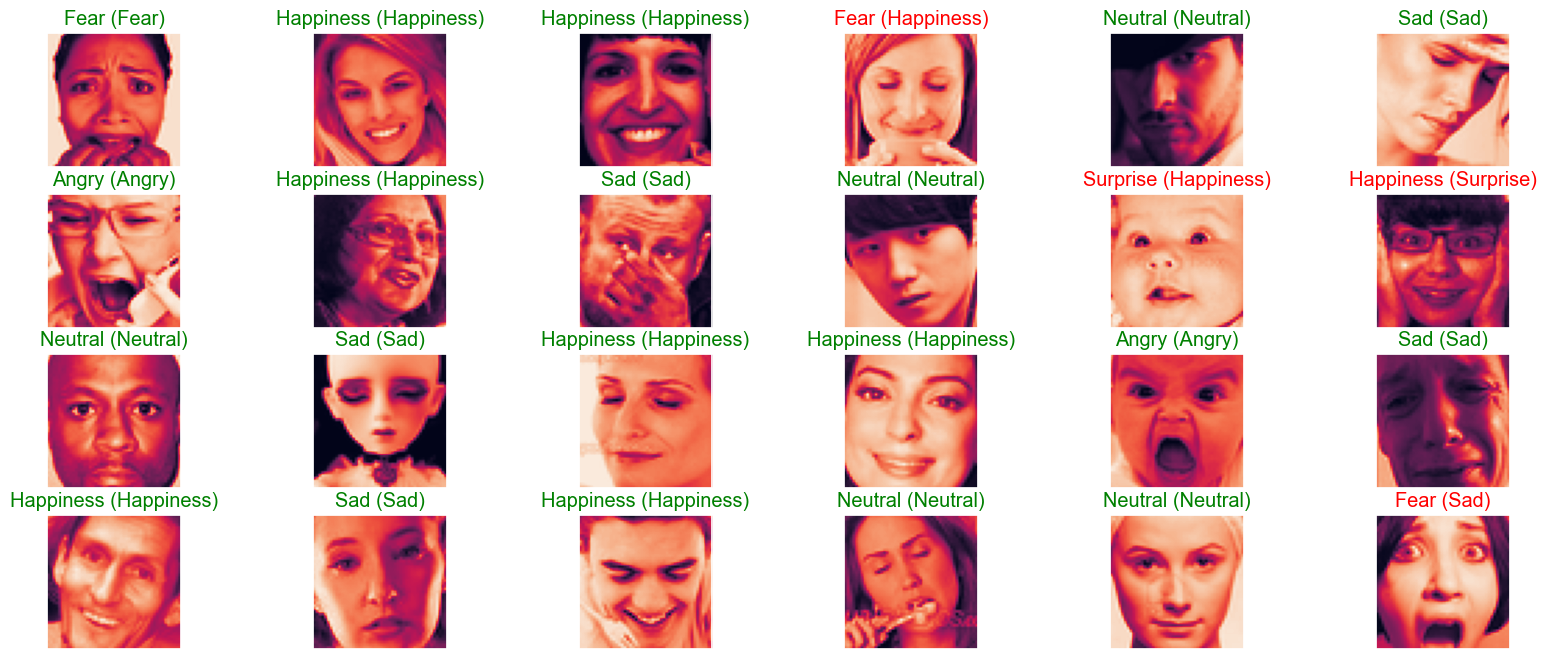

In [92]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))